In [1]:
import pandas as pd
from PIL import Image
import io
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt

In [ ]:
train_df = pd.read_parquet("./train.parquet")
print(train_df)

test_df  = pd.read_parquet("./test.parquet")

def bytes_to_pixels(b: bytes) -> np.ndarray:
    """
    Convert raw image bytes (e.g. JPEG/PNG) into a 2D numpy array of pixel values (grayscale).
    """
    img = Image.open(io.BytesIO(b))  # convert to grayscale
    return np.array(img)

def extract_bytes(blob):
    """
    Unwrap a dict‐wrapped binary payload if needed,
    otherwise return blob directly.
    """
    if isinstance(blob, dict):
        
        for key in ("bytes", "data", "image"):
            if key in blob and isinstance(blob[key], (bytes, bytearray)):
                return blob[key]
        
        for v in blob.values():
            if isinstance(v, (bytes, bytearray)):
                return v
        raise TypeError(f"No bytes found in dict payload: {list(blob.keys())}")
    return blob

train_df["image"] = train_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))
test_df["image"]  = test_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))
print(train_df['label'].unique())

                                                  image  label
0     {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
1     {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2     {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
3     {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
4     {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
...                                                 ...    ...
5115  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
5116  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
5117  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
5118  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
5119  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2

[5120 rows x 2 columns]
[2 0 3 1]


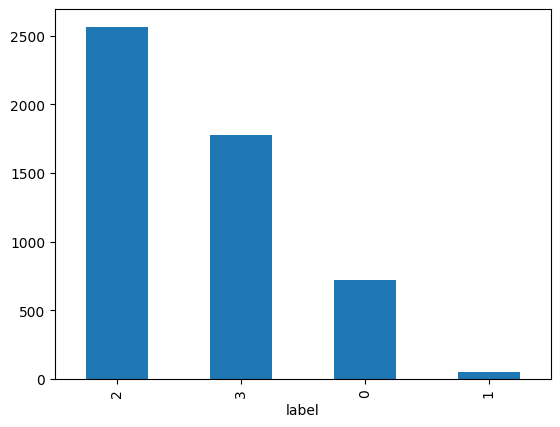

In [3]:
def display_images(df, n=10):
    """
    Display the first n grayscale images (numpy arrays) from df
    along with their labels. Assumes df has columns 'image' and 'label'.
    """
    for i, (_, row) in enumerate(df.head(n).iterrows(), start=1):
        pixels = row["image"]
        label = row.get("label", "")
        # Create a PIL image in 'L' mode (8-bit pixels, black and white)
        img = Image.fromarray(pixels.astype("uint8"), mode="L")
        print(f"{i}. label = {label}")
        display(img)
train_df['label'].value_counts().plot(kind='bar')

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'])


In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class MRIDatasetFromDF(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_array = self.df.iloc[idx]['image']
        label = int(self.df.iloc[idx]['label'])
        
        image = Image.fromarray(image_array.astype(np.uint8)).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [6]:
train_dataset = MRIDatasetFromDF(train_df, transform=train_transform)
val_dataset   = MRIDatasetFromDF(val_df, transform=test_transform)
test_dataset  = MRIDatasetFromDF(test_df, transform=test_transform)

# Weighted sampler for training
from torch.utils.data import WeightedRandomSampler

class_counts = train_df['label'].value_counts().sort_index().values
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in train_df['label']]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)


In [7]:
import torch.nn as nn

class MRIStageCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(MRIStageCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # compress to [batch, 128, 1, 1]
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                 # becomes [batch, 128]
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)  # use 3 or 4 depending on your labels
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [ ]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import efficientnet_b0

model = efficientnet_b0(pretrained=True)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)  # grayscale input
num_classes = len(train_df['label'].unique())
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_df['label']),
                                     y=train_df['label'].values)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [9]:
import torch.nn.functional as F

num_epochs = 30
best_val_acc = 0
patience_counter = 0
patience_limit = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        lam = np.random.beta(0.4, 0.4)
        index = torch.randperm(images.size(0))
        mixed_images = lam * images + (1 - lam) * images[index]
        #mixed_labels = lam * labels + (1 - lam) * labels[index]

        num_classes = outputs.size(1)
        labels_onehot = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
        labels_mixed = lam * labels_onehot + (1 - lam) * labels_onehot[index]

        outputs = model(mixed_images)
        loss = criterion(outputs, labels_mixed)
        #loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            # Convert labels to one-hot encoding
            labels_onehot = F.one_hot(labels, num_classes=num_classes).float()

            loss = criterion(outputs, labels_onehot)
            val_loss += loss.item()

            # For accuracy: convert logits to predicted class
            probs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(probs, dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print("Early stopping triggered.")
            break


Epoch [1/30] | Train Loss: 0.4499 | Val Loss: 0.4712 | Val Acc: 43.26%
Epoch [2/30] | Train Loss: 0.3928 | Val Loss: 0.4445 | Val Acc: 53.81%
Epoch [3/30] | Train Loss: 0.3704 | Val Loss: 0.3544 | Val Acc: 63.67%
Epoch [4/30] | Train Loss: 0.3760 | Val Loss: 0.3147 | Val Acc: 71.29%
Epoch [5/30] | Train Loss: 0.3424 | Val Loss: 0.2744 | Val Acc: 74.22%
Epoch [6/30] | Train Loss: 0.3328 | Val Loss: 0.3129 | Val Acc: 72.56%
Epoch [7/30] | Train Loss: 0.3220 | Val Loss: 0.2350 | Val Acc: 80.18%
Epoch [8/30] | Train Loss: 0.3051 | Val Loss: 0.1991 | Val Acc: 83.20%
Epoch [9/30] | Train Loss: 0.2900 | Val Loss: 0.2782 | Val Acc: 74.61%
Epoch [10/30] | Train Loss: 0.2958 | Val Loss: 0.1662 | Val Acc: 88.28%
Epoch [11/30] | Train Loss: 0.2727 | Val Loss: 0.2158 | Val Acc: 83.59%
Epoch [12/30] | Train Loss: 0.2658 | Val Loss: 0.1456 | Val Acc: 88.57%
Epoch [13/30] | Train Loss: 0.2679 | Val Loss: 0.1564 | Val Acc: 87.01%
Epoch [14/30] | Train Loss: 0.2628 | Val Loss: 0.1488 | Val Acc: 89.65%
E

In [10]:
torch.save(model.state_dict(), "./efficientnet_b0.pth")

In [11]:
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        print("Sample confidences:", probs[0].cpu().numpy())
        break  # just show one batch


Sample confidences: [9.0801751e-04 1.4234042e-03 6.0552941e-04 9.9706298e-01]


Test Accuracy: 93.67%
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       172
           1       1.00      0.93      0.97        15
           2       0.99      0.92      0.95       634
           3       0.87      0.98      0.92       459

    accuracy                           0.94      1280
   macro avg       0.95      0.93      0.94      1280
weighted avg       0.94      0.94      0.94      1280



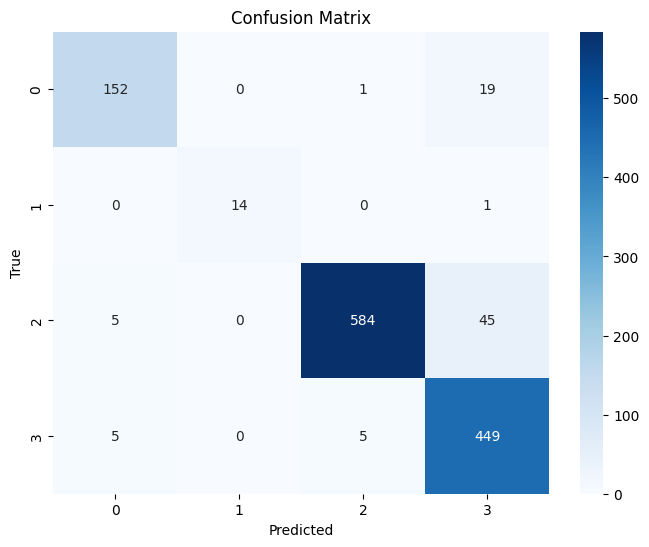

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100 * np.mean(np.array(all_preds) == np.array(all_labels)):.2f}%")
print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2

target_layer = model.features[-1]  # DenseNet121 last conv layer

#cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())
cam = GradCAM(model=model, target_layers=[target_layer])

# Pick a sample from val_df
sample = val_df.iloc[0]
image_array = sample['image']
label = int(sample['label'])

# Convert to PIL and apply test transform
image = Image.fromarray(image_array.astype(np.uint8)).convert('L')
input_tensor = test_transform(image).unsqueeze(0).to(device)

# Generate CAM
targets = [ClassifierOutputTarget(label)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# Overlay CAM
rgb_image = np.stack([image_array / 255.0] * 3, axis=-1)

# Resize CAM to match image dimensions
grayscale_cam_resized = cv2.resize(grayscale_cam, (rgb_image.shape[1], rgb_image.shape[0]))

# Overlay CAM
visualization = show_cam_on_image(rgb_image, grayscale_cam_resized, use_rgb=True)
#visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title(f"Grad-CAM for label {label}")
plt.axis('off')
plt.show()



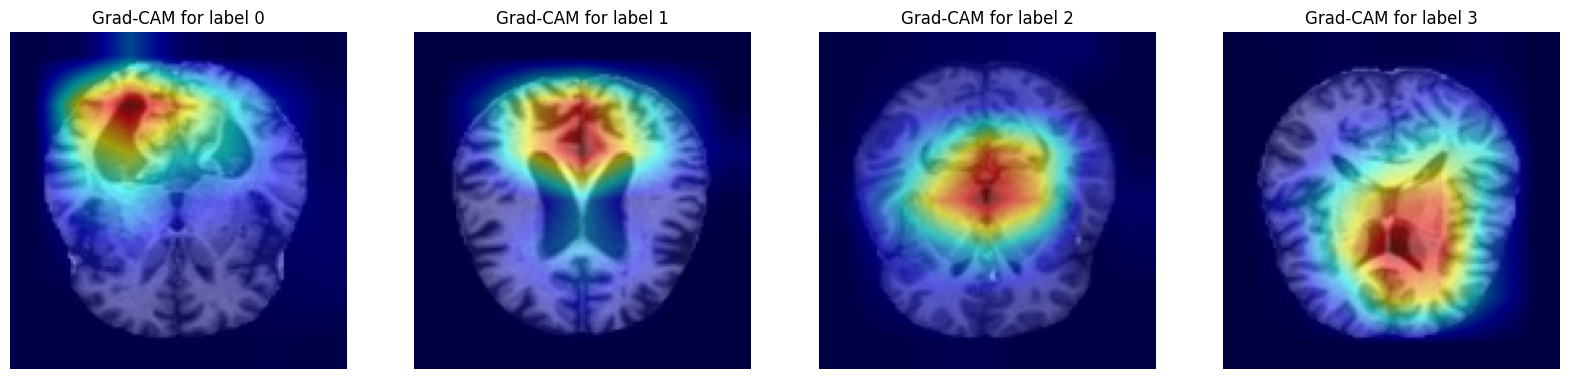

In [18]:
samples_by_label = [val_df[val_df['label'] == i].iloc[0] for i in range(4)]
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import cv2

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, sample in enumerate(samples_by_label):
    image_array = sample['image']
    label = int(sample['label'])

    image = Image.fromarray(image_array.astype(np.uint8)).convert('L')
    input_tensor = test_transform(image).unsqueeze(0).to(device)

    cam = GradCAM(model=model, target_layers=[target_layer])
    targets = [ClassifierOutputTarget(label)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Resize CAM to match image
    rgb_image = np.stack([image_array / 255.0] * 3, axis=-1)
    grayscale_cam_resized = cv2.resize(grayscale_cam, (rgb_image.shape[1], rgb_image.shape[0]))
    visualization = show_cam_on_image(rgb_image, grayscale_cam_resized, use_rgb=True)

    axs[i].imshow(visualization)
    axs[i].set_title(f"Grad-CAM for label {label}")
    axs[i].axis('off')
